In [1]:
import matplotlib.pyplot as plt
import scipy.sparse
%cd "~/moses-incons-pen-xp"
%load_ext autoreload
%autoreload 2

/home/xabush/moses-incons-pen-xp


In [332]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from notebooks.manifold_reg.MosesEstimator import *
from notebooks.manifold_reg.util import *

In [311]:
data_df = pd.read_csv("data/data_bm.csv", header=None)
assign_cols(data_df)
data_df.shape

(1000, 101)

In [312]:
data_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f92,f93,f94,f95,f96,f97,f98,f99,f100,y
0,1,0,0,1,1,1,0,1,1,1,...,0,1,1,1,0,0,0,1,1,0
1,0,1,0,1,1,1,0,1,1,1,...,0,1,1,0,1,0,1,1,1,0
2,0,0,0,1,1,1,0,1,1,1,...,0,1,1,0,0,0,1,1,0,0
3,0,1,0,1,1,1,0,1,1,1,...,0,1,1,0,1,0,1,1,0,0
4,1,0,0,1,0,1,0,1,1,1,...,0,1,1,0,0,1,1,1,0,0


In [313]:
X_df, y_df = data_df.iloc[:,:-1], data_df.iloc[:,-1:]

In [314]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, shuffle=True, stratify=y_df, test_size=0.2)

In [315]:
df_train = pd.concat([X_train_df, y_train_df], axis=1)
assign_cols(df_train)
df_test = pd.concat([X_test_df, y_test_df], axis=1)
assign_cols(df_test)
df_train.to_csv("data/bmm/data_train.csv", index=False)
df_test.to_csv("data/bmm/data_test.csv", index=False)

In [316]:
X_train, X_test, y_train, y_test = X_train_df.to_numpy(), X_test_df.to_numpy(), y_train_df.to_numpy(), y_test_df.to_numpy()

In [317]:
X_train.shape

(800, 100)

In [318]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [319]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([670, 130]))
(array([0, 1]), array([167,  33]))


In [320]:
net_df = pd.read_csv("data/feat_net.csv", header=None)
net_df.shape

(100, 100)

In [321]:
np.count_nonzero(net_df.to_numpy())

3196

In [322]:
assoc_mat = net_df.to_numpy()
assoc_mat = np.abs(assoc_mat)
assoc_mat_2 = np.copy(assoc_mat)
assoc_mat_2[assoc_mat_2 > 0.0] = 1.0

In [323]:
assoc_mat

array([[0.     , 1.518  , 0.     , ..., 0.     , 0.     , 0.     ],
       [1.518  , 0.     , 0.     , ..., 0.16892, 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 1.0094 , 0.5868 , 1.0373 ],
       ...,
       [0.     , 0.16892, 1.0094 , ..., 0.     , 0.29955, 0.     ],
       [0.     , 0.     , 0.5868 , ..., 0.29955, 0.     , 0.     ],
       [0.     , 0.     , 1.0373 , ..., 0.     , 0.     , 0.     ]])

In [324]:
np.save("data/bmm/feat_net.npy", assoc_mat)

In [302]:
kcv = StratifiedKFold(n_splits=5)

In [226]:
alphas = np.logspace(-3, 3, 10)
alphas = np.concatenate((np.array([0.0]) ,alphas))
alphas

array([0.00000000e+00, 1.00000000e-03, 4.64158883e-03, 2.15443469e-02,
       1.00000000e-01, 4.64158883e-01, 2.15443469e+00, 1.00000000e+01,
       4.64158883e+01, 2.15443469e+02, 1.00000000e+03])

In [303]:
cmplx_ratios = np.logspace(0, 3, 10)
cmplx_ratios

array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])

### Grid search using 5-fold cross-validation for $\alpha$ values and default complexity ratio (3.5) - using both BP and MI scorers

In [325]:
from notebooks.manifold_reg.MosesEstimator import *
cv_1 = GridSearchCV(MosesEstimator(scorers=["mi"], assoc_mat="data/bmm/feat_net.npy", fs_algo="smd", threshold=1e-5), {"alpha": alphas}, cv = kcv, verbose=1, n_jobs=-1).fit(X_train, y_train)
sc_1 = np.mean(cross_val_score(cv_1.best_estimator_, X_train, y_train))
cv_1.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_1.best_params_}, cv score: {sc_1}, test score: {cv_1.best_estimator_.score(X_test, y_test)}")

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best params: {'alpha': 0.0}, cv score: 0.5091773833424125, test score: 0.5121575031754672


### Grid search using 5-fold cross-validation for $\alpha$ values and complexity ratio values - using both BP and MI scorers

In [326]:
cv_1.best_estimator_.models_[10].model

'and(or(and(or(!$f11 !$f64) !$f36) and(or($f29 !$f64) !$f59)) or(!$f22 $f31 $f59))'

In [331]:
from notebooks.manifold_reg.MosesEstimator import *
cv_2 = GridSearchCV(MosesEstimator(scorers=["mi"], assoc_mat="data/bmm/feat_net.npy", fs_algo="smd", threshold=1e-5), {"alpha": alphas, "complexity_ratio": cmplx_ratios}, cv = kcv, verbose=1, n_jobs=-1).fit(X_train, y_train)
sc_2 = np.mean(cross_val_score(cv_2.best_estimator_, X_train, y_train))
cv_2.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_2.best_params_}, cv score: {sc_2}, test score: {cv_2.best_estimator_.score(X_test, y_test)}")

Best params: {'alpha': 0.0, 'complexity_ratio': 2.154434690031884}, cv score: 0.5018619623480809, test score: 0.5031754672473235


In [ ]:
cv_2.best_estimator_.models_[4].model

### Grid search using 5-fold cross-validation for complexity ratio values - using MI scorer

In [ ]:
from notebooks.manifold_reg.MosesEstimator import *
cv_3 = GridSearchCV(MosesEstimator(scorers=["mi"], fs_algo="smd", threshold=1e-5), {"complexity_ratio": cmplx_ratios}, cv = kcv, verbose=1, n_jobs=-1).fit(X_train, y_train)
sc_3 = np.mean(cross_val_score(cv_3.best_estimator_, X_train, y_train))
cv_3.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_3.best_params_}, cv score: {sc_3}, test score: {cv_3.best_estimator_.score(X_test, y_test)}")

In [ ]:
cv_3.best_estimator_.models_[0].model

### Grid search using 5-fold cross-validation for $\alpha$ values, complexity ratio values and feature target size - using both BP and MI scorers

In [254]:
from notebooks.manifold_reg.MosesEstimator import *
cv_4 = GridSearchCV(MosesEstimator(scorers=["mi"], assoc_mat="data/bmm/feat_net.npy", fs_algo="smd", threshold=1e-5), {"alpha": alphas, "complexity_ratio": cmplx_ratios, "fs_size": [5, 10, 15, 20]}, cv = kcv, verbose=1, n_jobs=-1).fit(X_train, y_train)
sc_4 = np.mean(cross_val_score(cv_4.best_estimator_, X_train, y_train))
cv_4.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_4.best_params_}, cv score: {sc_4}, test score: {cv_4.best_estimator_.score(X_test, y_test)}")

Best params: {'alpha': 10.0, 'complexity_ratio': 46.41588833612777, 'fs_size': 5}, cv score: 0.5812774162360872, test score: 0.586352657004831


In [246]:
from notebooks.manifold_reg.MosesEstimator import *
moses_est = MosesEstimator(scorers=["mi"], assoc_mat="data/bmm/feat_net.npy", fs_algo="smd", threshold=0.001, ensemble=True)
moses_est.models_ = cv_1.best_estimator_.models_
moses_est.score(X_test, y_test)

0.586352657004831

In [131]:
assoc_mat = np.load("data/bmm/feat_net.npy")
# assoc_mat = np.abs(assoc_mat)
assoc_mat

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
dist_mat, precd = scipy.sparse.csgraph.shortest_path(scipy.sparse.csc_matrix(assoc_mat), directed=False, method="J", return_predecessors=True)
dist_mat[1, np.array([79, 260, 293, 637, 839])]

array([0.043899 , 0.0427118, 0.0473448, 0.0342591, 0.0396434])

In [216]:
assoc_mat[34][np.array([26,8,31,96,94])]

array([0.    , 2.0186, 0.    , 1.764 , 0.    ])

In [281]:
from notebooks.manifold_reg.MosesEstimator import *

dict(sorted(feature_count(cv_2.best_estimator_.models_, [7,25,30,93,95], assoc_mat).items()))

{2: {'count': 8, 'causal': 'No', 'dist': 1.74594},
 12: {'count': 3, 'causal': 'No', 'dist': 0.76589},
 14: {'count': 18, 'causal': 'No', 'dist': 1.1222},
 17: {'count': 1, 'causal': 'No', 'dist': 2.7237299999999998},
 18: {'count': 2, 'causal': 'No', 'dist': 0.0},
 21: {'count': 8, 'causal': 'No', 'dist': 3.25655},
 22: {'count': 3, 'causal': 'No', 'dist': 0.5194799999999999},
 23: {'count': 7, 'causal': 'No', 'dist': 0.25111},
 33: {'count': 2, 'causal': 'No', 'dist': 1.32917},
 35: {'count': 7, 'causal': 'No', 'dist': 1.2426006},
 41: {'count': 1, 'causal': 'No', 'dist': 1.65511},
 49: {'count': 12, 'causal': 'No', 'dist': 2.3459499999999998},
 51: {'count': 2, 'causal': 'No', 'dist': 1.3791},
 56: {'count': 1, 'causal': 'No', 'dist': 2.24722},
 62: {'count': 3, 'causal': 'No', 'dist': 0.0},
 63: {'count': 1, 'causal': 'No', 'dist': 2.2205},
 65: {'count': 6, 'causal': 'No', 'dist': 0.0},
 71: {'count': 1, 'causal': 'No', 'dist': 1.322663},
 77: {'count': 1, 'causal': 'No', 'dist': 

In [280]:
dict(sorted(feature_count(cv_3.best_estimator_.models_, [7,25,30,93,95], assoc_mat).items()))

{0: {'count': 114, 'causal': 'No', 'dist': 2.493685},
 25: {'count': 46, 'causal': 'Yes', 'dist': 2.16739},
 28: {'count': 79, 'causal': 'No', 'dist': 0.81464},
 55: {'count': 1, 'causal': 'No', 'dist': 2.47713},
 59: {'count': 113, 'causal': 'No', 'dist': 0.24626},
 61: {'count': 103, 'causal': 'No', 'dist': 1.2174},
 62: {'count': 94, 'causal': 'No', 'dist': 0.0},
 80: {'count': 9, 'causal': 'No', 'dist': 1.0437},
 86: {'count': 24, 'causal': 'No', 'dist': 1.1383},
 91: {'count': 8, 'causal': 'No', 'dist': 2.8305},
 93: {'count': 102, 'causal': 'Yes', 'dist': 0.0},
 96: {'count': 107, 'causal': 'No', 'dist': 1.3618}}

In [334]:
from notebooks.manifold_reg.util import load_bmm_files
seeds, data_dfs, net_dfs, feats = load_bmm_files("data/bmm_data")
seeds

[82, 91, 13, 92, 64, 10, 28, 55, 96, 97]

In [ ]:
from notebooks.manifold_reg.MosesEstimator import run_moses_exps

res_1 = run_moses_exps(seeds, data_dfs, net_dfs, alphas, cmplx_ratios)
res_1

Now running seed - 82
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 10.0}, cv score: 0.5179456421127495, test score: 0.5113504381797064
Now running seed - 91
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.001, 'complexity_ratio': 1000.0}, cv score: 0.5248731795123547, test score: 0.5
Now running seed - 13
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.1, 'complexity_ratio': 21.544346900318832}, cv score: 0.5161818544837413, test score: 0.48685383244206776
Now running seed - 92
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.46415888336127775, 'complexity_ratio': 46.41588833612777}, cv score: 0.5186099259189797, test score: 0.5260391782130912
Now running seed - 64
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.1, 'complexity_ratio': 215.44346900318823}, cv score:

In [337]:
res_1

{82: {'params': {'alpha': 0.0, 'complexity_ratio': 10.0},
  'cv_score': 0.5179456421127495,
  'test_score': 0.5113504381797064},
 91: {'params': {'alpha': 0.001, 'complexity_ratio': 1000.0},
  'cv_score': 0.5248731795123547,
  'test_score': 0.5},
 13: {'params': {'alpha': 0.1, 'complexity_ratio': 21.544346900318832},
  'cv_score': 0.5161818544837413,
  'test_score': 0.48685383244206776},
 92: {'params': {'alpha': 0.46415888336127775,
   'complexity_ratio': 46.41588833612777},
  'cv_score': 0.5186099259189797,
  'test_score': 0.5260391782130912},
 64: {'params': {'alpha': 0.1, 'complexity_ratio': 215.44346900318823},
  'cv_score': 0.508962731434037,
  'test_score': 0.49328859060402686},
 10: {'params': {'alpha': 0.021544346900318832, 'complexity_ratio': 1.0},
  'cv_score': 0.5635189669087974,
  'test_score': 0.5697599794634836},
 28: {'params': {'alpha': 0.0, 'complexity_ratio': 464.15888336127773},
  'cv_score': 0.533251589202081,
  'test_score': 0.5},
 55: {'params': {'alpha': 0.1, 'c

In [354]:
target_count = {}

for seed, df in zip(seeds, data_dfs):
    count = df["y"].value_counts()
    target_count[seed] = [count[0], count[1]]

target_count

{82: [614, 386],
 91: [606, 394],
 13: [659, 341],
 92: [804, 196],
 64: [747, 253],
 10: [737, 263],
 28: [861, 139],
 55: [619, 381],
 96: [838, 162],
 97: [563, 437]}

In [388]:
base_auc = []
with open("data/bmm_data/base_auc.txt", "r") as fp:
    base_auc = [float(i) for i in fp.readline().strip().split(',')]

base_auc

[0.597319032590167,
 0.609970514817979,
 0.604939947222976,
 0.604077825159915,
 0.688818515167389,
 0.688819125939607,
 0.698209376749472,
 0.636555022706168,
 0.624421756681104,
 0.504932305278603]

In [409]:
from notebooks.manifold_reg.MosesEstimator import result_df
res_1_df = result_df(res_1, target_count, base_auc)
res_1_df

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,0.000000,10.000000,0.517946,0.511350,614/386,0.597319
1,91,0.001000,1000.000000,0.524873,0.500000,606/394,0.609971
2,13,0.100000,21.544347,0.516182,0.486854,659/341,0.604940
3,92,0.464159,46.415888,0.518610,0.526039,804/196,0.604078
4,64,0.100000,215.443469,0.508963,0.493289,747/253,0.688819
5,10,0.021544,1.000000,0.563519,0.569760,737/263,0.688819
6,28,0.000000,464.158883,0.533252,0.500000,861/139,0.698209
7,55,0.100000,2.154435,0.559960,0.475806,619/381,0.636555
8,96,0.464159,215.443469,0.507807,0.500000,838/162,0.624422
9,97,0.464159,21.544347,0.534286,0.525633,563/437,0.504932


In [360]:
res_1_df.to_csv("data/bmm_seeds_result.csv", index=False)

In [384]:
from notebooks.manifold_reg.MosesEstimator import *
res_2 = run_moses_exps(seeds, data_dfs, net_dfs, alphas, cmplx_ratios, fs_algo="random")

Now running seed - 82
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.004641588833612777, 'complexity_ratio': 1000.0}, cv score: 0.5128573587023387, test score: 0.4959349593495935
Now running seed - 91
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 2.154434690031884}, cv score: 0.5364588447062675, test score: 0.47960037660843186
Now running seed - 13
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.46415888336127775, 'complexity_ratio': 1.0}, cv score: 0.5254719703776307, test score: 0.5465686274509803
Now running seed - 92
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.021544346900318832, 'complexity_ratio': 4.641588833612778}, cv score: 0.5202853447736934, test score: 0.509714922758401
Now running seed - 64
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best params: {'alpha': 0.0, 'compl

In [408]:
from notebooks.manifold_reg.MosesEstimator import result_df
res_2_df = result_df(res_2, target_count, base_auc)
res_2_df

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,0.004642,1000.000000,0.512857,0.495935,614/386,0.597319
1,91,0.000000,2.154435,0.536459,0.479600,606/394,0.609971
2,13,0.464159,1.000000,0.525472,0.546569,659/341,0.604940
3,92,0.021544,4.641589,0.520285,0.509715,804/196,0.604078
4,64,0.000000,46.415888,0.504693,0.483221,747/253,0.688819
5,10,0.100000,464.158883,0.575585,0.560326,737/263,0.688819
6,28,0.021544,10.000000,0.533033,0.514950,861/139,0.698209
7,55,0.021544,2.154435,0.586438,0.543294,619/381,0.636555
8,96,0.000000,4.641589,0.513375,0.494048,838/162,0.624422
9,97,2.154435,1.000000,0.514603,0.467196,563/437,0.504932


In [402]:
data_df = data_dfs[0]
X_df, y_df = data_df.iloc[:, :-1], data_df.iloc[:, -1:]
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, shuffle=True, stratify=y_df,
                                                                test_size=0.2, random_state=82)

X_train, X_test, y_train, y_test = X_train_df.to_numpy(), X_test_df.to_numpy(), y_train_df.to_numpy(), y_test_df.to_numpy()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
moses_est_2 = MosesEstimator(scorers=["mi"], alpha=0.0, fs_algo="smd", random_state=82, complexity_ratio=10.0).fit(X_train, y_train)

In [403]:
moses_est_2.score(X_test, y_test)

0.49836342519269344

In [405]:
feature_count(moses_est_2.models_, feats[0], np.abs(net_dfs[0].to_numpy()))

{17: {'count': 21, 'causal': 'No', 'dist': 0.9601299999999999},
 92: {'count': 308, 'causal': 'No', 'dist': 0.97088},
 94: {'count': 208, 'causal': 'No', 'dist': 0.0},
 6: {'count': 117, 'causal': 'No', 'dist': 0.48908},
 45: {'count': 108, 'causal': 'No', 'dist': 1.1862400000000002},
 54: {'count': 305, 'causal': 'No', 'dist': 1.8189},
 48: {'count': 106, 'causal': 'No', 'dist': 1.0801},
 85: {'count': 113, 'causal': 'No', 'dist': 3.24872},
 47: {'count': 106, 'causal': 'No', 'dist': 0.5104181},
 66: {'count': 113, 'causal': 'No', 'dist': 0.85802},
 30: {'count': 110, 'causal': 'No', 'dist': 2.15778},
 86: {'count': 14, 'causal': 'No', 'dist': 0.0},
 36: {'count': 9, 'causal': 'No', 'dist': 1.3718599999999999}}

In [ ]:
from notebooks.manifold_reg.MosesEstimator import *

# no background penalty

res_3 = run_moses_exps(seeds, data_dfs, net_dfs)

Now running seed - 82
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 10}, cv score: 0.49522815327756026, test score: 0.49836342519269344
Now running seed - 91
Fitting 5 folds for each of 1 candidates, totalling 5 fits


### No background penalty - complexity ratio = 10 for all runs

In [410]:
res_3_df = result_df(res_3, target_count, base_auc)
res_3_df

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,0.0,10,0.495228,0.498363,614/386,0.597319
1,91,0.0,10,0.500671,0.502458,606/394,0.609971
2,13,0.0,10,0.503950,0.503342,659/341,0.604940
3,92,0.0,10,0.535325,0.500000,804/196,0.604078
4,64,0.0,10,0.495819,0.496644,747/253,0.688819
5,10,0.0,10,0.549556,0.496599,737/263,0.688819
6,28,0.0,10,0.498545,0.512043,861/139,0.698209
7,55,0.0,10,0.528068,0.475806,619/381,0.636555
8,96,0.0,10,0.503100,0.497024,838/162,0.624422
9,97,0.0,10,0.484127,0.503509,563/437,0.504932


In [414]:
from notebooks.manifold_reg.MosesEstimator import *
alpha_vals = np.logspace(-3, 3, 15)


#background penalty with fixed complexity ratio
res_4 = run_moses_exps(seeds, data_dfs, net_dfs, alphas=alpha_vals)

Now running seed - 82
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 1.0, 'complexity_ratio': 10}, cv score: 0.5199717798758366, test score: 0.4788301129764544
Now running seed - 91
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.3727593720314938, 'complexity_ratio': 10}, cv score: 0.5158402880052364, test score: 0.5299717543676117
Now running seed - 13
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.0071968567300115215, 'complexity_ratio': 10}, cv score: 0.5105576882935373, test score: 0.49153297682709446
Now running seed - 92
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.0071968567300115215, 'complexity_ratio': 10}, cv score: 0.5178165635158789, test score: 0.5
Now running seed - 64
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.13894954943731375, 'complexity_ratio': 10}, cv score: 0.50665966386

### Background penalty - complexity ratio = 10 for all runs

In [415]:
res_4_df = result_df(res_4, target_count, base_auc)
res_4_df

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,1.000000,10,0.519972,0.478830,614/386,0.597319
1,91,0.372759,10,0.515840,0.529972,606/394,0.609971
2,13,0.007197,10,0.510558,0.491533,659/341,0.604940
3,92,0.007197,10,0.517817,0.500000,804/196,0.604078
4,64,0.138950,10,0.506660,0.493025,747/253,0.688819
5,10,0.001000,10,0.535432,0.500000,737/263,0.688819
6,28,0.019307,10,0.517650,0.517857,861/139,0.698209
7,55,0.372759,10,0.584153,0.487903,619/381,0.636555
8,96,0.001000,10,0.503215,0.497024,838/162,0.624422
9,97,0.019307,10,0.522540,0.538806,563/437,0.504932


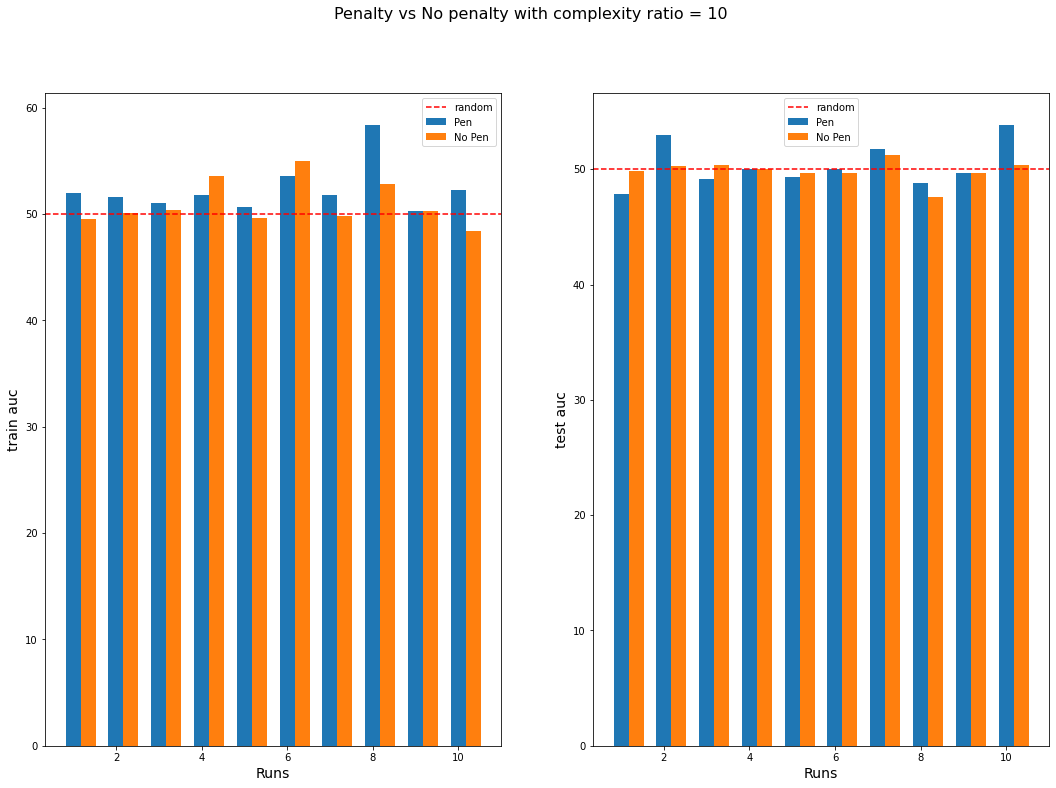

In [498]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle("Penalty vs No penalty with complexity ratio = 10", fontsize=16)

index = np.arange(1, 11)
bar_width = 0.35
ax[0].bar(index, res_4_df["cv_score"]*100, bar_width, label="Pen")
ax[0].bar(index + bar_width, res_3_df["cv_score"]*100, bar_width, label="No Pen")
ax[0].axhline(y=50, color="red", label="random", linestyle="--")
ax[0].set_xlabel("Seeds", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)

ax[1].bar(index, res_4_df["test_score"]*100, bar_width, label="Pen")
ax[1].bar(index + bar_width, res_3_df["test_score"]*100, bar_width, label="No Pen")
ax[1].set_xlabel("Seeds", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[1].axhline(y=50, color="red", label="random", linestyle="--")

ax[0].legend()
ax[1].legend()

In [420]:
from notebooks.manifold_reg.MosesEstimator import *
res_5 = run_moses_exps(seeds, data_dfs, net_dfs, cmplx_ratios=[1000])
res_5_df = result_df(res_5, target_count, base_auc)
res_5_df

Now running seed - 82
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 1000}, cv score: 0.504554606163732, test score: 0.49018055115616094
Now running seed - 91
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 1000}, cv score: 0.5078874161348388, test score: 0.4960246887749764
Now running seed - 13
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 1000}, cv score: 0.5049415085264142, test score: 0.5071301247771836
Now running seed - 92
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 1000}, cv score: 0.5024506126531633, test score: 0.5
Now running seed - 64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'alpha': 0.0, 'complexity_ratio': 1000}, cv score: 0.5038667418186787, test score: 0.5030925121726543
Now running seed - 10
Fitting 

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,0.0,1000,0.504555,0.490181,614/386,0.597319
1,91,0.0,1000,0.507887,0.496025,606/394,0.609971
2,13,0.0,1000,0.504942,0.507130,659/341,0.604940
3,92,0.0,1000,0.502451,0.500000,804/196,0.604078
4,64,0.0,1000,0.503867,0.503093,747/253,0.688819
5,10,0.0,1000,0.504479,0.488256,737/263,0.688819
6,28,0.0,1000,0.513423,0.514950,861/139,0.698209
7,55,0.0,1000,0.525418,0.506579,619/381,0.636555
8,96,0.0,1000,0.497761,0.515625,838/162,0.624422
9,97,0.0,1000,0.494444,0.495575,563/437,0.504932


In [419]:

alpha_vals = np.logspace(-3, 3, 15)

#background penalty with fixed complexity ratio
res_6 = run_moses_exps(seeds, data_dfs, net_dfs, alphas=alpha_vals, cmplx_ratios=[1000])
res_6_df = result_df(res_6, target_count, base_auc)
res_6_df

Now running seed - 82
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.0071968567300115215, 'complexity_ratio': 1000}, cv score: 0.5048922403761115, test score: 0.4617780593390349
Now running seed - 91
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.001, 'complexity_ratio': 1000}, cv score: 0.5248731795123547, test score: 0.5
Now running seed - 13
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 7.196856730011514, 'complexity_ratio': 1000}, cv score: 0.5128232005590496, test score: 0.5
Now running seed - 92
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.0026826957952797246, 'complexity_ratio': 1000}, cv score: 0.5072631439109777, test score: 0.4968944099378882
Now running seed - 64
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'alpha': 0.0026826957952797246, 'complexity_ratio': 1000}, cv score: 0.50320437931270

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,0.007197,1000,0.504892,0.461778,614/386,0.597319
1,91,0.001000,1000,0.524873,0.500000,606/394,0.609971
2,13,7.196857,1000,0.512823,0.500000,659/341,0.604940
3,92,0.002683,1000,0.507263,0.496894,804/196,0.604078
4,64,0.002683,1000,0.503204,0.509541,747/253,0.688819
5,10,0.002683,1000,0.547215,0.514696,737/263,0.688819
6,28,0.138950,1000,0.510738,0.500000,861/139,0.698209
7,55,0.002683,1000,0.555671,0.504244,619/381,0.636555
8,96,51.794747,1000,0.503100,0.500000,838/162,0.624422
9,97,0.138950,1000,0.516032,0.487082,563/437,0.504932


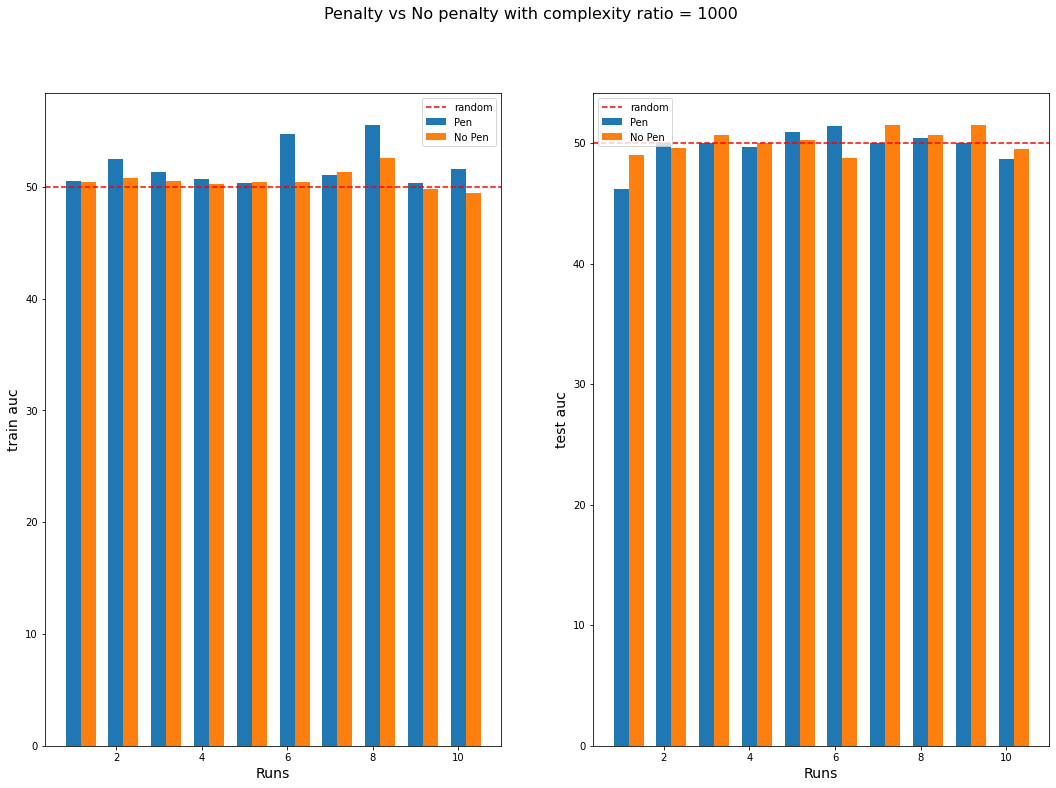

In [502]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle("Penalty vs No penalty with complexity ratio = 1000", fontsize=16)

index = np.arange(1, 11)
bar_width = 0.35
ax[0].bar(index, res_6_df["cv_score"]*100, bar_width, label="Pen")
ax[0].bar(index + bar_width, res_5_df["cv_score"]*100, bar_width, label="No Pen")
ax[0].axhline(y=50, color="red", label="random", linestyle="--")
ax[0].set_xlabel("Runs", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)

ax[1].bar(index, res_6_df["test_score"]*100, bar_width, label="Pen")
ax[1].bar(index + bar_width, res_5_df["test_score"]*100, bar_width, label="No Pen")
ax[1].set_xlabel("Runs", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[1].axhline(y=50, color="red", label="random", linestyle="--")

ax[0].legend()
ax[1].legend()

In [427]:
from sklearn.feature_selection import mutual_info_classif

df_mi_t = pd.read_csv("data/bmm/data_train.csv")
X_mi_t, y_mi_t = df_mi_t.iloc[:, :-1].to_numpy(), df_mi_t.iloc[:, -1:].to_numpy()
print(X_mi_t.shape)
feat_mi = mutual_info_classif(X_mi_t, y_mi_t)
feat_mi

(800, 100)


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.67879235e-03, 0.00000000e+00, 2.57947553e-02, 3.78504319e-03,
       1.46083745e-04, 3.60399591e-03, 1.07635042e-03, 3.20701608e-03,
       0.00000000e+00, 2.47437766e-03, 0.00000000e+00, 1.40363090e-02,
       0.00000000e+00, 9.11492550e-03, 2.23379202e-03, 0.00000000e+00,
       0.00000000e+00, 8.71900214e-03, 1.08000755e-02, 3.97140979e-03,
       4.69913343e-03, 2.35717977e-02, 6.35922335e-03, 0.00000000e+00,
       9.92519500e-03, 1.36775564e-02, 0.00000000e+00, 4.66560251e-03,
       2.37800344e-02, 6.64740063e-03, 8.06451397e-03, 0.00000000e+00,
       0.00000000e+00, 1.72473443e-03, 8.00179417e-03, 0.00000000e+00,
       1.39951224e-03, 4.99036299e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.27337466e-03, 0.00000000e+00, 1.15324812e-02,
       0.00000000e+00, 0.00000000e+00, 1.50868649e-02, 2.29527861e-02,
       1.16404034e-02, 0.00000000e+00, 9.31363906e-03, 2.37345269e-02,
       1.72497214e-02, 0.00000000e+00, 0.00000000e+00, 7.30247922e-03,
      

In [431]:
np.sum(feat_mi[np.array([8, 29, 56, 58, 62, 64])])

0.032396213062007906

### Using the stand-alone feature selection binary - i.e pre-selecting the features outside of MOSES

In [540]:
from notebooks.manifold_reg.MosesEstimator import *
from sklearn.model_selection import cross_val_score
import subprocess as subp

i = 0

results_fs = {}
for seed, df in zip(seeds, data_dfs):
    X_s, y_s = df[df.columns.difference(["y"])], df["y"]
    X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, stratify=y_s, shuffle=True, random_state=seed)
    data_train_s = pd.concat([X_s_train, y_s_train], axis=1)
    data_train_s.to_csv(f"data/exps5/data_train_{seed}.csv", index=False)
    cmd = ["asfeature-selection", "-i", f"data/exps5/data_train_{seed}.csv",  "-uy", "-asmd", "-C10", "-o", f"data/exps5/data_train_r_{seed}.csv", "-F", "data/exps5/fs.log"]
    process = subp.Popen(args=cmd, stdout=subp.PIPE, stderr=subp.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        raise RuntimeError(f"MOSES ran into an error with return code {process.returncode}. Here is the stderr output:\n{stderr.decode('utf-8')}")

    data_r = pd.read_csv(f"data/exps5/data_train_r_{seed}.csv")
    cols = [col for col in data_r.columns if col != "y"] + ["y"] # asfeature-selection doesn't output columns in the order its given so fix it here
    data_r = data_r[cols]
    X_r_train, y_r_train = data_r[data_r.columns.difference(["y"])].to_numpy(), data_r["y"].to_numpy()
    X_r_test = X_s_test[cols[:-1]]
    cv_score = np.mean(cross_val_score(MosesEstimator(fs_algo=None, random_state=seed, cols=cols), X_r_train, y_r_train, n_jobs=-1))
    moses_est_r = MosesEstimator(fs_algo=None, random_state=seed, cols=cols).fit(X_r_train, y_r_train)
    # print("Scoring on test dataset")
    test_score = moses_est_r.score(X_r_test.to_numpy(), y_s_test.to_numpy())
    res = {"cv_score": cv_score, "test_score": test_score, "est": moses_est_r}
    print(res)
    results_fs[seed] = res


    i += 1

{'cv_score': 0.5273565616408451, 'test_score': 0.47486692271410286, 'est': MosesEstimator(cols=['f30', 'f33', 'f34', 'f36', 'f39', 'f51', 'f68', 'f85',
                     'f88', 'f94', 'y'],
               fs_algo=None, random_state=82)}
{'cv_score': 0.5398173966180201, 'test_score': 0.5077873254564984, 'est': MosesEstimator(cols=['f18', 'f40', 'f47', 'f54', 'f56', 'f63', 'f7', 'f71',
                     'f84', 'f95', 'y'],
               fs_algo=None, random_state=91)}
{'cv_score': 0.5514606181352327, 'test_score': 0.5433155080213904, 'est': MosesEstimator(cols=['f20', 'f31', 'f32', 'f34', 'f48', 'f5', 'f63', 'f66',
                     'f68', 'f74', 'y'],
               fs_algo=None, random_state=13)}
{'cv_score': 0.5240760037588978, 'test_score': 0.5005076657528683, 'est': MosesEstimator(cols=['f16', 'f23', 'f25', 'f3', 'f36', 'f39', 'f42', 'f57',
                     'f63', 'f93', 'y'],
               fs_algo=None, random_state=92)}
{'cv_score': 0.5329518684980641, 'test_score':

In [541]:
results_fs_df = {"seed": [] ,"cv_score": [], "test_score": []}

for s, v in results_fs.items():
    results_fs_df["seed"].append(s)
    results_fs_df["cv_score"].append(v["cv_score"])
    results_fs_df["test_score"].append(v["test_score"])

results_fs_df = pd.DataFrame(results_fs_df)
results_fs_df

,seed,cv_score,test_score
0,82,0.527357,0.474867
1,91,0.539817,0.507787
2,13,0.551461,0.543316
3,92,0.524076,0.500508
4,64,0.532952,0.534250
5,10,0.569539,0.569170
6,28,0.559812,0.553156
7,55,0.583921,0.585739
8,96,0.533092,0.498214
9,97,0.552088,0.539788


In [539]:
results_fs_init = {}
i = 0
for seed, df in zip(seeds, data_dfs):
    X_s, y_s = df[df.columns.difference(["y"])], df["y"]
    X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, stratify=y_s, shuffle=True, random_state=seed)

    data_train_s = pd.concat([X_s_train, y_s_train], axis=1)
    data_train_s.to_csv(f"data/exps5/data_train_{seed}.csv", index=False)
    cmd = ["asfeature-selection", "-i", f"data/exps5/data_train_{seed}.csv",  "-uy", "-asmd", "-C10", "-o", f"data/exps5/data_train_r_{seed}.csv", "-F", f"data/exps5/fs_{seed}_init.log"]
    for f in feats[i]:
        cmd.append(f"-ff{f}")
    process = subp.Popen(args=cmd, stdout=subp.PIPE, stderr=subp.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        raise RuntimeError(f"MOSES ran into an error with return code {process.returncode}. Here is the stderr output:\n{stderr.decode('utf-8')}")

    data_r = pd.read_csv(f"data/exps5/data_train_r_{seed}.csv")
    cols = [col for col in data_r.columns if col != "y"] + ["y"] # asfeature-selection doesn't output columns in the order its given so fix it here
    data_r = data_r[cols]
    X_r_train, y_r_train = data_r[data_r.columns.difference(["y"])].to_numpy(), data_r["y"].to_numpy()
    X_r_test = X_s_test[cols[:-1]]
    cv_score = np.mean(cross_val_score(MosesEstimator(fs_algo=None, random_state=seed, cols=cols), X_r_train, y_r_train, n_jobs=-1))
    moses_est_r = MosesEstimator(fs_algo=None, random_state=seed, cols=cols).fit(X_r_train, y_r_train)
    # print("Scoring on test dataset")
    test_score = moses_est_r.score(X_r_test.to_numpy(), y_s_test.to_numpy())
    res = {"cv_score": cv_score, "test_score": test_score, "est": moses_est_r}
    print(res)
    results_fs_init[seed] = res
    i += 1

results_fs_init

{'cv_score': 0.538178280394043, 'test_score': 0.4899602452664915, 'est': MosesEstimator(cols=['f11', 'f17', 'f39', 'f48', 'f49', 'f51', 'f57', 'f83',
                     'f88', 'f94', 'y'],
               fs_algo=None, random_state=82)}
{'cv_score': 0.576702016470924, 'test_score': 0.543501611170784, 'est': MosesEstimator(cols=['f18', 'f38', 'f4', 'f47', 'f54', 'f69', 'f7', 'f77',
                     'f84', 'f92', 'y'],
               fs_algo=None, random_state=91)}
{'cv_score': 0.5555092072234149, 'test_score': 0.5167557932263815, 'est': MosesEstimator(cols=['f18', 'f22', 'f5', 'f52', 'f60', 'f66', 'f75', 'f76',
                     'f89', 'f90', 'y'],
               fs_algo=None, random_state=13)}
{'cv_score': 0.534995089230352, 'test_score': 0.5206619961417404, 'est': MosesEstimator(cols=['f12', 'f16', 'f25', 'f36', 'f39', 'f42', 'f62', 'f63',
                     'f79', 'f93', 'y'],
               fs_algo=None, random_state=92)}
{'cv_score': 0.5503332761383852, 'test_score': 0.52

{82: {'cv_score': 0.538178280394043,
  'test_score': 0.4899602452664915,
  'est': MosesEstimator(cols=['f11', 'f17', 'f39', 'f48', 'f49', 'f51', 'f57', 'f83',
                       'f88', 'f94', 'y'],
                 fs_algo=None, random_state=82)},
 91: {'cv_score': 0.576702016470924,
  'test_score': 0.543501611170784,
  'est': MosesEstimator(cols=['f18', 'f38', 'f4', 'f47', 'f54', 'f69', 'f7', 'f77',
                       'f84', 'f92', 'y'],
                 fs_algo=None, random_state=91)},
 13: {'cv_score': 0.5555092072234149,
  'test_score': 0.5167557932263815,
  'est': MosesEstimator(cols=['f18', 'f22', 'f5', 'f52', 'f60', 'f66', 'f75', 'f76',
                       'f89', 'f90', 'y'],
                 fs_algo=None, random_state=13)},
 92: {'cv_score': 0.534995089230352,
  'test_score': 0.5206619961417404,
  'est': MosesEstimator(cols=['f12', 'f16', 'f25', 'f36', 'f39', 'f42', 'f62', 'f63',
                       'f79', 'f93', 'y'],
                 fs_algo=None, random_state=9

In [569]:
results_fs_init_df = {"seed": [] ,"cv_score": [], "test_score": []}

for s, v in results_fs_init.items():
    results_fs_init_df["seed"].append(s)
    results_fs_init_df["cv_score"].append(v["cv_score"])
    results_fs_init_df["test_score"].append(v["test_score"])

results_fs_init_df = pd.DataFrame(results_fs_init_df)
results_fs_init_df

,seed,cv_score,test_score
0,82,0.538178,0.489960
1,91,0.576702,0.543502
2,13,0.555509,0.516756
3,92,0.534995,0.520662
4,64,0.550333,0.523470
5,10,0.580634,0.559453
6,28,0.547512,0.540864
7,55,0.552298,0.625297
8,96,0.518685,0.495238
9,97,0.539476,0.498699


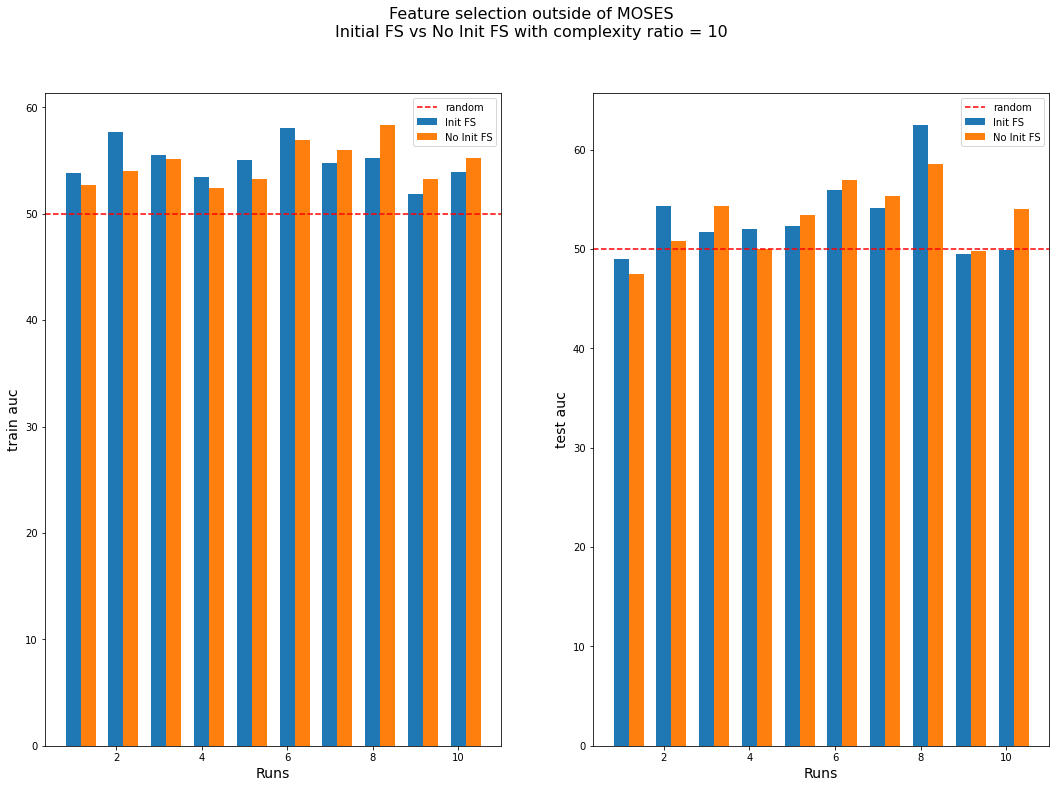

In [556]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle("Feature selection outside of MOSES\nInitial FS vs No Init FS with complexity ratio = 10", fontsize=16)

index = np.arange(1, 11)
bar_width = 0.35
ax[0].bar(index, results_fs_init_df["cv_score"]*100, bar_width, label="Init FS")
ax[0].bar(index + bar_width, results_fs_df["cv_score"]*100, bar_width, label="No Init FS")
ax[0].axhline(y=50, color="red", label="random", linestyle="--")
ax[0].set_xlabel("Runs", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)

ax[1].bar(index, results_fs_init_df["test_score"]*100, bar_width, label="Init FS")
ax[1].bar(index + bar_width, results_fs_df["test_score"]*100, bar_width, label="No Init FS")
ax[1].set_xlabel("Runs", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[1].axhline(y=50, color="red", label="random", linestyle="--")

ax[0].legend()
ax[1].legend()

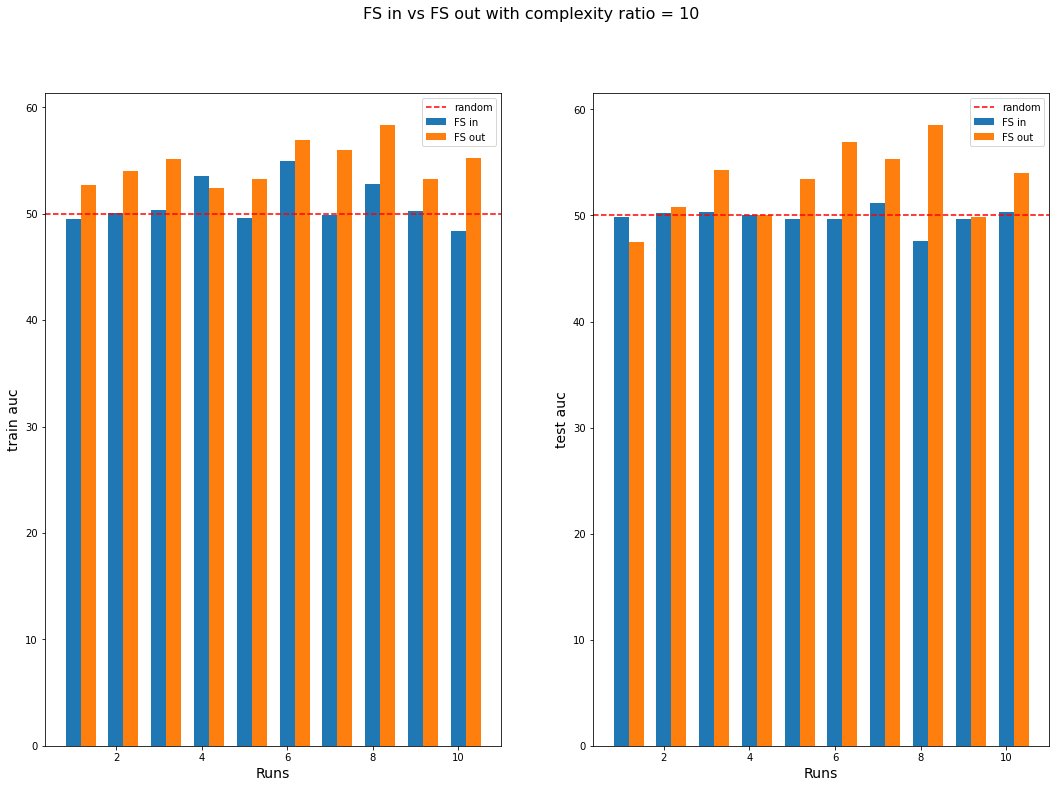

In [554]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle("FS in vs FS out with complexity ratio = 10", fontsize=16)

index = np.arange(1, 11)
bar_width = 0.35
ax[0].bar(index, res_3_df["cv_score"]*100, bar_width, label="FS in")
ax[0].bar(index + bar_width, results_fs_df["cv_score"]*100, bar_width, label="FS out")
ax[0].axhline(y=50, color="red", label="random", linestyle="--")
ax[0].set_xlabel("Runs", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)

ax[1].bar(index, res_3_df["test_score"]*100, bar_width, label="FS in")
ax[1].bar(index + bar_width, results_fs_df["test_score"]*100, bar_width, label="FS out")
ax[1].set_xlabel("Runs", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[1].axhline(y=50, color="red", label="random", linestyle="--")

ax[0].legend()
ax[1].legend()

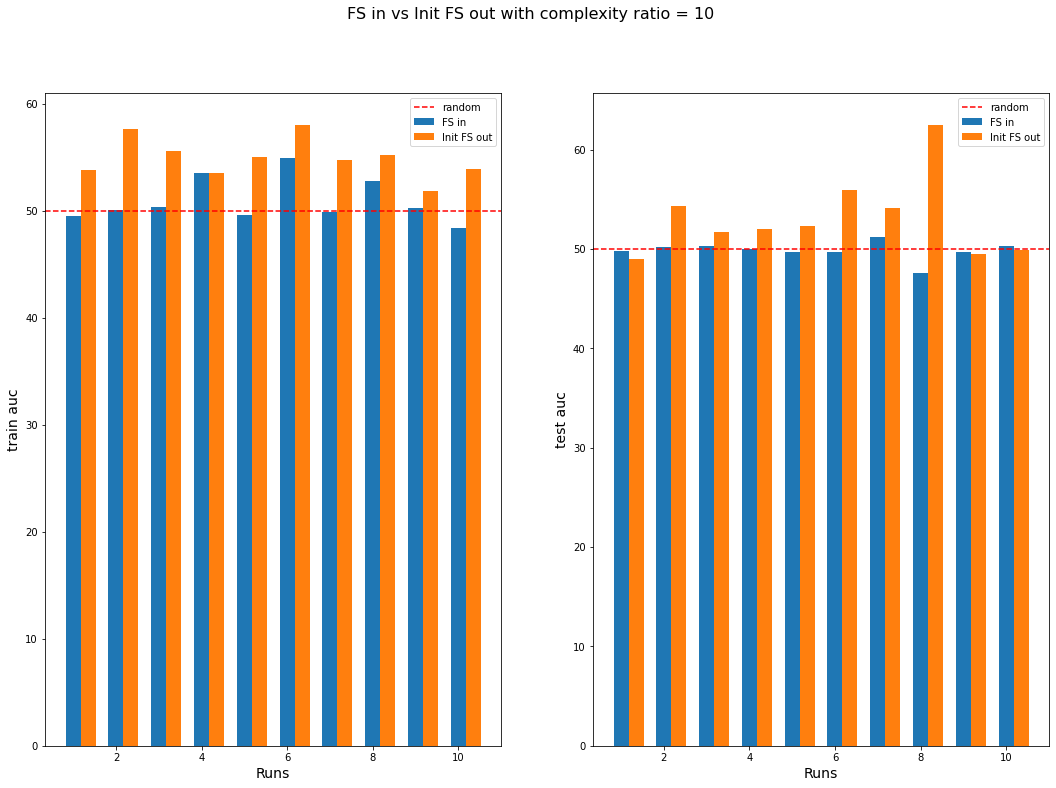

In [555]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle("FS in vs Init FS out with complexity ratio = 10", fontsize=16)

index = np.arange(1, 11)
bar_width = 0.35
ax[0].bar(index, res_3_df["cv_score"]*100, bar_width, label="FS in")
ax[0].bar(index + bar_width, results_fs_init_df["cv_score"]*100, bar_width, label="Init FS out")
ax[0].axhline(y=50, color="red", label="random", linestyle="--")
ax[0].set_xlabel("Runs", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)

ax[1].bar(index, res_3_df["test_score"]*100, bar_width, label="FS in")
ax[1].bar(index + bar_width, results_fs_init_df["test_score"]*100, bar_width, label="Init FS out")
ax[1].set_xlabel("Runs", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[1].axhline(y=50, color="red", label="random", linestyle="--")

ax[0].legend()
ax[1].legend()

In [558]:
results_bp_fs = {}
i = 0
for seed, df in zip(seeds, data_dfs):
    X_s, y_s = df[df.columns.difference(["y"])], df["y"]
    X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, stratify=y_s, random_state=seed)
    data_train_s = pd.concat([X_s_train, y_s_train], axis=1)
    data_train_s.to_csv(f"data/exps5/data_train_{seed}.csv", index=False)
    net_df = net_dfs[i]
    assoc_mat = net_df.to_numpy()
    assoc_mat = np.abs(assoc_mat)

    net_file = tmp.NamedTemporaryFile(suffix=".npy").name
    np.save(net_file, assoc_mat)

    cmd = ["asfeature-selection", "-i", f"data/exps5/data_train_{seed}.csv",  "-uy", "-asmd", "-C10", "-o", f"data/exps5/data_train_r_{seed}.csv", "-F", f"data/exps5/fs_{seed}_init.log",
           "--fs-alpha", "0.001", "--fs-assoc-mat", net_file, "-H", "mi", "-H", "bp"]
    process = subp.Popen(args=cmd, stdout=subp.PIPE, stderr=subp.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        raise RuntimeError(f"MOSES ran into an error with return code {process.returncode}. Here is the stderr output:\n{stderr.decode('utf-8')}")

    data_r = pd.read_csv(f"data/exps5/data_train_r_{seed}.csv")
    cols = [col for col in data_r.columns if col != "y"] + ["y"] # asfeature-selection doesn't output columns in the order its given so fix it here
    data_r = data_r[cols]
    X_r_train, y_r_train = data_r[data_r.columns.difference(["y"])].to_numpy(), data_r["y"].to_numpy()
    X_r_test = X_s_test[cols[:-1]]
    cv_score = np.mean(cross_val_score(MosesEstimator(fs_algo=None, random_state=seed, cols=cols), X_r_train, y_r_train, n_jobs=-1))
    moses_est_r = MosesEstimator(fs_algo=None, random_state=seed, cols=cols).fit(X_r_train, y_r_train)
    # print("Scoring on test dataset")
    test_score = moses_est_r.score(X_r_test.to_numpy(), y_s_test.to_numpy())
    res = {"cv_score": cv_score, "test_score": test_score, "est": moses_est_r}
    print(res)
    results_bp_fs[seed] = res
    i += 1

results_bp_fs

{'cv_score': 0.5273565616408451, 'test_score': 0.47486692271410286, 'est': MosesEstimator(cols=['f30', 'f33', 'f34', 'f36', 'f39', 'f51', 'f68', 'f85',
                     'f88', 'f94', 'y'],
               fs_algo=None, random_state=82)}
{'cv_score': 0.5398173966180201, 'test_score': 0.5077873254564984, 'est': MosesEstimator(cols=['f18', 'f40', 'f47', 'f54', 'f56', 'f63', 'f7', 'f71',
                     'f84', 'f95', 'y'],
               fs_algo=None, random_state=91)}
{'cv_score': 0.5514606181352327, 'test_score': 0.5433155080213904, 'est': MosesEstimator(cols=['f20', 'f31', 'f32', 'f34', 'f48', 'f5', 'f63', 'f66',
                     'f68', 'f74', 'y'],
               fs_algo=None, random_state=13)}
{'cv_score': 0.5240760037588978, 'test_score': 0.5005076657528683, 'est': MosesEstimator(cols=['f16', 'f23', 'f25', 'f3', 'f36', 'f39', 'f42', 'f57',
                     'f63', 'f93', 'y'],
               fs_algo=None, random_state=92)}
{'cv_score': 0.5120429255733784, 'test_score':

{82: {'cv_score': 0.5273565616408451,
  'test_score': 0.47486692271410286,
  'est': MosesEstimator(cols=['f30', 'f33', 'f34', 'f36', 'f39', 'f51', 'f68', 'f85',
                       'f88', 'f94', 'y'],
                 fs_algo=None, random_state=82)},
 91: {'cv_score': 0.5398173966180201,
  'test_score': 0.5077873254564984,
  'est': MosesEstimator(cols=['f18', 'f40', 'f47', 'f54', 'f56', 'f63', 'f7', 'f71',
                       'f84', 'f95', 'y'],
                 fs_algo=None, random_state=91)},
 13: {'cv_score': 0.5514606181352327,
  'test_score': 0.5433155080213904,
  'est': MosesEstimator(cols=['f20', 'f31', 'f32', 'f34', 'f48', 'f5', 'f63', 'f66',
                       'f68', 'f74', 'y'],
                 fs_algo=None, random_state=13)},
 92: {'cv_score': 0.5240760037588978,
  'test_score': 0.5005076657528683,
  'est': MosesEstimator(cols=['f16', 'f23', 'f25', 'f3', 'f36', 'f39', 'f42', 'f57',
                       'f63', 'f93', 'y'],
                 fs_algo=None, random_st

In [567]:
results_bp_df = {"seed": [] ,"cv_score": [], "test_score": []}

for s, v in results_bp_fs.items():
    results_bp_df["seed"].append(s)
    results_bp_df["cv_score"].append(v["cv_score"])
    results_bp_df["test_score"].append(v["test_score"])

results_bp_df = pd.DataFrame(results_bp_df)
results_bp_df

,seed,cv_score,test_score
0,82,0.527357,0.474867
1,91,0.539817,0.507787
2,13,0.551461,0.543316
3,92,0.524076,0.500508
4,64,0.512043,0.518207
5,10,0.569539,0.569170
6,28,0.559812,0.553156
7,55,0.583921,0.585739
8,96,0.533092,0.498214
9,97,0.552088,0.539788


In [572]:
results_log_init = {}
i = 0
for seed, df in zip(seeds, data_dfs):
    X_s, y_s = df[df.columns.difference(["y"])], df["y"]
    X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, stratify=y_s, random_state=seed)
    data_train_s = pd.concat([X_s_train, y_s_train], axis=1)
    data_train_s.to_csv(f"data/exps5/data_train_{seed}.csv", index=False)
    cmd = ["asfeature-selection", "-i", f"data/exps5/data_train_{seed}.csv",  "-uy", "-asmd", "-C10", "-o", f"data/exps5/data_train_r_{seed}.csv", "-F", f"data/exps5/fs_{seed}_init.log"]
    for f in feats[i]:
        cmd.append(f"-ff{f}")
    process = subp.Popen(args=cmd, stdout=subp.PIPE, stderr=subp.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        raise RuntimeError(f"MOSES ran into an error with return code {process.returncode}. Here is the stderr output:\n{stderr.decode('utf-8')}")

    data_r = pd.read_csv(f"data/exps5/data_train_r_{seed}.csv")
    cols = [col for col in data_r.columns if col != "y"] + ["y"] # asfeature-selection doesn't output columns in the order its given so fix it here
    data_r = data_r[cols]
    X_r_train, y_r_train = data_r[data_r.columns.difference(["y"])].to_numpy(), data_r["y"].to_numpy()
    X_r_test = X_s_test[cols[:-1]]
    cv_score = np.mean(cross_val_score(LogisticRegression(random_state=seed, C=1e9), X_r_train, y_r_train, scoring="roc_auc", n_jobs=-1))
    moses_est_r = LogisticRegression(random_state=seed, C=1e9).fit(X_r_train, y_r_train)
    # print("Scoring on test dataset")
    test_score = roc_auc_score(y_s_test.to_numpy() ,moses_est_r.predict_proba(X_r_test.to_numpy())[:,1])
    res = {"cv_score": cv_score, "test_score": test_score, "est": moses_est_r}
    print(res)
    results_log_init[seed] = res
    i += 1

results_log_init

{'cv_score': 0.641690643076877, 'test_score': 0.5910652920962199, 'est': LogisticRegression(C=1000000000.0, random_state=82)}
{'cv_score': 0.6196976711298745, 'test_score': 0.6322838345864662, 'est': LogisticRegression(C=1000000000.0, random_state=91)}
{'cv_score': 0.6267915596697109, 'test_score': 0.6065953654188949, 'est': LogisticRegression(C=1000000000.0, random_state=13)}
{'cv_score': 0.6361489503182293, 'test_score': 0.546603716113311, 'est': LogisticRegression(C=1000000000.0, random_state=92)}
{'cv_score': 0.706062030075188, 'test_score': 0.6673457261692556, 'est': LogisticRegression(C=1000000000.0, random_state=64)}
{'cv_score': 0.694481561981562, 'test_score': 0.6742012516469038, 'est': LogisticRegression(C=1000000000.0, random_state=10)}
{'cv_score': 0.7012904279183348, 'test_score': 0.6544186046511627, 'est': LogisticRegression(C=1000000000.0, random_state=28)}
{'cv_score': 0.62259248134846, 'test_score': 0.6629541595925297, 'est': LogisticRegression(C=1000000000.0, random_s

{82: {'cv_score': 0.641690643076877,
  'test_score': 0.5910652920962199,
  'est': LogisticRegression(C=1000000000.0, random_state=82)},
 91: {'cv_score': 0.6196976711298745,
  'test_score': 0.6322838345864662,
  'est': LogisticRegression(C=1000000000.0, random_state=91)},
 13: {'cv_score': 0.6267915596697109,
  'test_score': 0.6065953654188949,
  'est': LogisticRegression(C=1000000000.0, random_state=13)},
 92: {'cv_score': 0.6361489503182293,
  'test_score': 0.546603716113311,
  'est': LogisticRegression(C=1000000000.0, random_state=92)},
 64: {'cv_score': 0.706062030075188,
  'test_score': 0.6673457261692556,
  'est': LogisticRegression(C=1000000000.0, random_state=64)},
 10: {'cv_score': 0.694481561981562,
  'test_score': 0.6742012516469038,
  'est': LogisticRegression(C=1000000000.0, random_state=10)},
 28: {'cv_score': 0.7012904279183348,
  'test_score': 0.6544186046511627,
  'est': LogisticRegression(C=1000000000.0, random_state=28)},
 55: {'cv_score': 0.62259248134846,
  'test_s

### MOSES Maximizes AUC instead of accuracy

### No background penalty - complexity ratio = 10 for all runs

In [ ]:
roc_auc_score

In [590]:
from notebooks.manifold_reg.MosesEstimator import *
res_5 = run_moses_exps(seeds, data_dfs, net_dfs)
res_5_df = result_df(res_5, target_count, base_auc)
res_5_df

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,0.0,10,0.533748,0.520748,614/386,0.597319
1,91,0.0,10,0.550974,0.533895,606/394,0.609971
2,13,0.0,10,0.529686,0.610071,659/341,0.604940
3,92,0.0,10,0.507516,0.435260,804/196,0.604078
4,64,0.0,10,0.536285,0.459074,747/253,0.688819
5,10,0.0,10,0.597861,0.601335,737/263,0.688819
6,28,0.0,10,0.542666,0.446013,861/139,0.698209
7,55,0.0,10,0.545587,0.505942,619/381,0.636555
8,96,0.0,10,0.562400,0.421131,838/162,0.624422
9,97,0.0,10,0.527619,0.472841,563/437,0.504932


### Background penalty - complexity ratio = 10 for all runs

In [591]:
res_6 = run_moses_exps(seeds, data_dfs, net_dfs, alphas=alphas)
res_6_df = result_df(res_6, target_count, base_auc)
res_6_df

,seed,alpha,complexity_ratio,cv_score,test_score,0/1,base_auc
0,82,2.154435,10,0.542848,0.592810,614/386,0.597319
1,91,0.000000,10,0.547799,0.533895,606/394,0.609971
2,13,46.415888,10,0.548028,0.473485,659/341,0.604940
3,92,10.000000,10,0.545764,0.544912,804/196,0.604078
4,64,10.000000,10,0.603477,0.590472,747/253,0.688819
5,10,0.464159,10,0.612591,0.623347,737/263,0.688819
6,28,10.000000,10,0.612838,0.463870,861/139,0.698209
7,55,2.154435,10,0.555340,0.504457,619/381,0.636555
8,96,10.000000,10,0.638806,0.561756,838/162,0.624422
9,97,1000.000000,10,0.525397,0.500000,563/437,0.504932


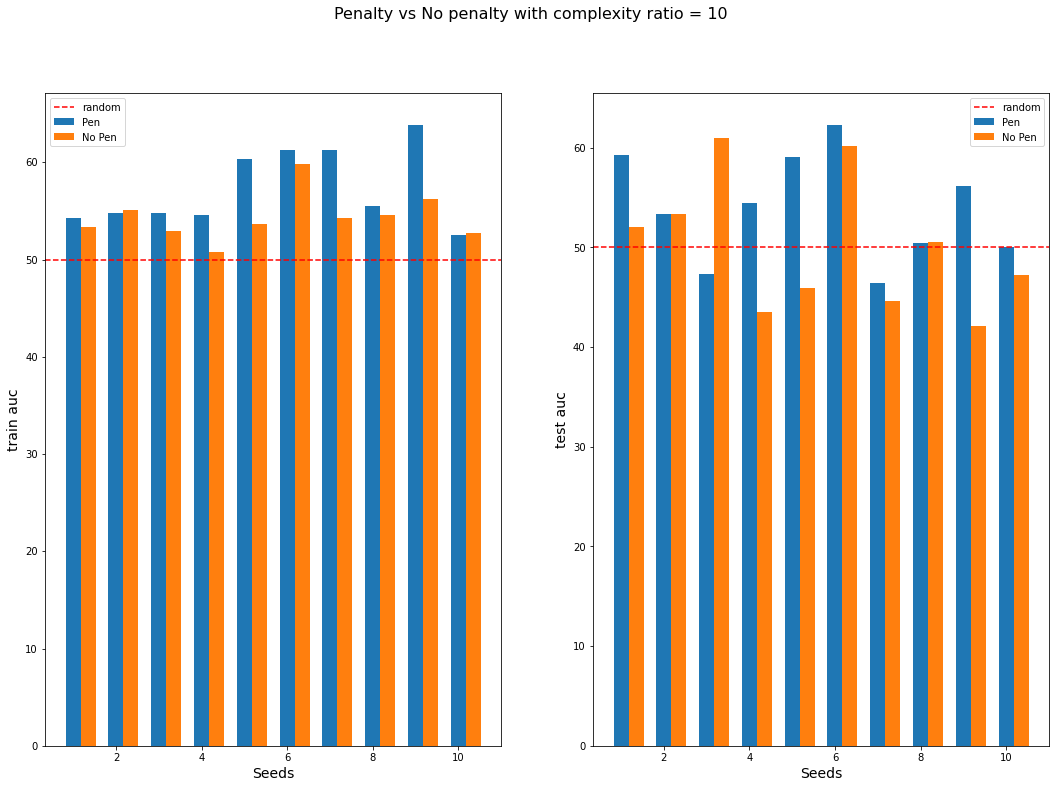

In [592]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle("Penalty vs No penalty with complexity ratio = 10", fontsize=16)

index = np.arange(1, 11)
bar_width = 0.35
ax[0].bar(index, res_6_df["cv_score"]*100, bar_width, label="Pen")
ax[0].bar(index + bar_width, res_5_df["cv_score"]*100, bar_width, label="No Pen")
ax[0].axhline(y=50, color="red", label="random", linestyle="--")
ax[0].set_xlabel("Seeds", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)

ax[1].bar(index, res_6_df["test_score"]*100, bar_width, label="Pen")
ax[1].bar(index + bar_width, res_5_df["test_score"]*100, bar_width, label="No Pen")
ax[1].set_xlabel("Seeds", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[1].axhline(y=50, color="red", label="random", linestyle="--")

ax[0].legend()
ax[1].legend()

In [596]:
from notebooks.manifold_reg.MosesEstimator import *
from sklearn.model_selection import cross_val_score
import subprocess as subp

i = 0

results_fs_auc = {}
for seed, df in zip(seeds, data_dfs):
    X_s, y_s = df[df.columns.difference(["y"])], df["y"]
    X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, stratify=y_s, shuffle=True, random_state=seed)
    data_train_s = pd.concat([X_s_train, y_s_train], axis=1)
    data_train_s.to_csv(f"data/exps5/data_train_{seed}.csv", index=False)
    cmd = ["asfeature-selection", "-i", f"data/exps5/data_train_{seed}.csv",  "-uy", "-asmd", "-C10", "-o", f"data/exps5/data_train_r_{seed}.csv", "-F", "data/exps5/fs.log"]
    process = subp.Popen(args=cmd, stdout=subp.PIPE, stderr=subp.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        raise RuntimeError(f"MOSES ran into an error with return code {process.returncode}. Here is the stderr output:\n{stderr.decode('utf-8')}")

    data_r = pd.read_csv(f"data/exps5/data_train_r_{seed}.csv")
    cols = [col for col in data_r.columns if col != "y"] + ["y"] # asfeature-selection doesn't output columns in the order its given so fix it here
    data_r = data_r[cols]
    X_r_train, y_r_train = data_r[data_r.columns.difference(["y"])].to_numpy(), data_r["y"].to_numpy()
    X_r_test = X_s_test[cols[:-1]]
    cv_score = np.mean(cross_val_score(MosesEstimator(fs_algo=None, random_state=seed, cols=cols), X_r_train, y_r_train, n_jobs=-1))
    moses_est_r = MosesEstimator(fs_algo=None, random_state=seed, cols=cols).fit(X_r_train, y_r_train)
    # print("Scoring on test dataset")
    test_score = moses_est_r.score(X_r_test.to_numpy(), y_s_test.to_numpy())
    res = {"cv_score": cv_score, "test_score": test_score, "est": moses_est_r}
    print(res)
    results_fs_auc[seed] = res


    i += 1

{'cv_score': 0.5913948283566307, 'test_score': 0.5809244660063339, 'est': MosesEstimator(cols=['f30', 'f33', 'f34', 'f36', 'f39', 'f51', 'f68', 'f85',
                     'f88', 'f94', 'y'],
               fs_algo=None, random_state=82)}
{'cv_score': 0.6005903152297839, 'test_score': 0.5967373791621913, 'est': MosesEstimator(cols=['f18', 'f40', 'f47', 'f54', 'f56', 'f63', 'f7', 'f71',
                     'f84', 'f95', 'y'],
               fs_algo=None, random_state=91)}
{'cv_score': 0.5762324696459771, 'test_score': 0.5297682709447415, 'est': MosesEstimator(cols=['f20', 'f31', 'f32', 'f34', 'f48', 'f5', 'f63', 'f66',
                     'f68', 'f74', 'y'],
               fs_algo=None, random_state=13)}
{'cv_score': 0.6001277764972237, 'test_score': 0.5070565539648695, 'est': MosesEstimator(cols=['f16', 'f23', 'f25', 'f3', 'f36', 'f39', 'f42', 'f57',
                     'f63', 'f93', 'y'],
               fs_algo=None, random_state=92)}
{'cv_score': 0.6601037375377148, 'test_score': 

In [600]:
from notebooks.manifold_reg.MosesEstimator import *
from sklearn.model_selection import cross_val_score
import subprocess as subp
results_fs_init_auc = {}
i = 0
for seed, df in zip(seeds, data_dfs):
    X_s, y_s = df[df.columns.difference(["y"])], df["y"]
    X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, stratify=y_s, shuffle=True, random_state=seed)

    data_train_s = pd.concat([X_s_train, y_s_train], axis=1)
    data_train_s.to_csv(f"data/exps5/data_train_{seed}.csv", index=False)
    cmd = ["asfeature-selection", "-i", f"data/exps5/data_train_{seed}.csv",  "-uy", "-asmd", "-C10", "-o", f"data/exps5/data_train_r_{seed}.csv", "-F", f"data/exps5/fs_{seed}_init.log"]
    for f in feats[i]:
        cmd.append(f"-ff{f}")
    process = subp.Popen(args=cmd, stdout=subp.PIPE, stderr=subp.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        raise RuntimeError(f"MOSES ran into an error with return code {process.returncode}. Here is the stderr output:\n{stderr.decode('utf-8')}")

    data_r = pd.read_csv(f"data/exps5/data_train_r_{seed}.csv")
    cols = [col for col in data_r.columns if col != "y"] + ["y"] # asfeature-selection doesn't output columns in the order its given so fix it here
    data_r = data_r[cols]
    X_r_train, y_r_train = data_r[data_r.columns.difference(["y"])].to_numpy(), data_r["y"].to_numpy()
    X_r_test = X_s_test[cols[:-1]]
    cv_score = np.mean(cross_val_score(MosesEstimator(fs_algo=None, random_state=seed, cols=cols), X_r_train, y_r_train, n_jobs=-1))
    moses_est_r = MosesEstimator(fs_algo=None, random_state=seed, cols=cols).fit(X_r_train, y_r_train)
    # print("Scoring on test dataset")
    test_score = moses_est_r.score(X_r_test.to_numpy(), y_s_test.to_numpy())
    res = {"cv_score": cv_score, "test_score": test_score, "est": moses_est_r}
    print(res)
    results_fs_init_auc[seed] = res
    i += 1  

results_fs_init_auc

{'cv_score': 0.5973767635060001, 'test_score': 0.5758708981874536, 'est': MosesEstimator(cols=['f11', 'f17', 'f39', 'f48', 'f49', 'f51', 'f57', 'f83',
                     'f88', 'f94', 'y'],
               fs_algo=None, random_state=82)}
{'cv_score': 0.5975352204194708, 'test_score': 0.6441326530612245, 'est': MosesEstimator(cols=['f18', 'f38', 'f4', 'f47', 'f54', 'f69', 'f7', 'f77',
                     'f84', 'f92', 'y'],
               fs_algo=None, random_state=91)}
{'cv_score': 0.6120142881265829, 'test_score': 0.5935828877005348, 'est': MosesEstimator(cols=['f18', 'f22', 'f5', 'f52', 'f60', 'f66', 'f75', 'f76',
                     'f89', 'f90', 'y'],
               fs_algo=None, random_state=13)}
{'cv_score': 0.6073084096947914, 'test_score': 0.45009645649304497, 'est': MosesEstimator(cols=['f12', 'f16', 'f25', 'f36', 'f39', 'f42', 'f62', 'f63',
                     'f79', 'f93', 'y'],
               fs_algo=None, random_state=92)}
{'cv_score': 0.6732089040503385, 'test_score':

{82: {'cv_score': 0.5973767635060001,
  'test_score': 0.5758708981874536,
  'est': MosesEstimator(cols=['f11', 'f17', 'f39', 'f48', 'f49', 'f51', 'f57', 'f83',
                       'f88', 'f94', 'y'],
                 fs_algo=None, random_state=82)},
 91: {'cv_score': 0.5975352204194708,
  'test_score': 0.6441326530612245,
  'est': MosesEstimator(cols=['f18', 'f38', 'f4', 'f47', 'f54', 'f69', 'f7', 'f77',
                       'f84', 'f92', 'y'],
                 fs_algo=None, random_state=91)},
 13: {'cv_score': 0.6120142881265829,
  'test_score': 0.5935828877005348,
  'est': MosesEstimator(cols=['f18', 'f22', 'f5', 'f52', 'f60', 'f66', 'f75', 'f76',
                       'f89', 'f90', 'y'],
                 fs_algo=None, random_state=13)},
 92: {'cv_score': 0.6073084096947914,
  'test_score': 0.45009645649304497,
  'est': MosesEstimator(cols=['f12', 'f16', 'f25', 'f36', 'f39', 'f42', 'f62', 'f63',
                       'f79', 'f93', 'y'],
                 fs_algo=None, random_st

In [603]:
results_fs_auc_df = {"seed": [] ,"cv_score": [], "test_score": []}
results_fs_init_auc_df = {"seed": [] ,"cv_score": [], "test_score": []}

for s, v in results_fs_auc.items():
    results_fs_auc_df["seed"].append(s)
    results_fs_auc_df["cv_score"].append(v["cv_score"])
    results_fs_auc_df["test_score"].append(v["test_score"])

for s, v in results_fs_init_auc.items():
    results_fs_init_auc_df["seed"].append(s)
    results_fs_init_auc_df["cv_score"].append(v["cv_score"])
    results_fs_init_auc_df["test_score"].append(v["test_score"])

results_fs_auc_df = pd.DataFrame(results_fs_auc_df)
results_fs_init_auc_df = pd.DataFrame(results_fs_init_auc_df)

In [604]:
results_fs_init_auc_df

,seed,cv_score,test_score
0,82,0.597377,0.575871
1,91,0.597535,0.644133
2,13,0.612014,0.593583
3,92,0.607308,0.450096
4,64,0.673209,0.566718
5,10,0.594349,0.605567
6,28,0.648507,0.607973
7,55,0.597970,0.590662
8,96,0.622044,0.550000
9,97,0.525062,0.564090


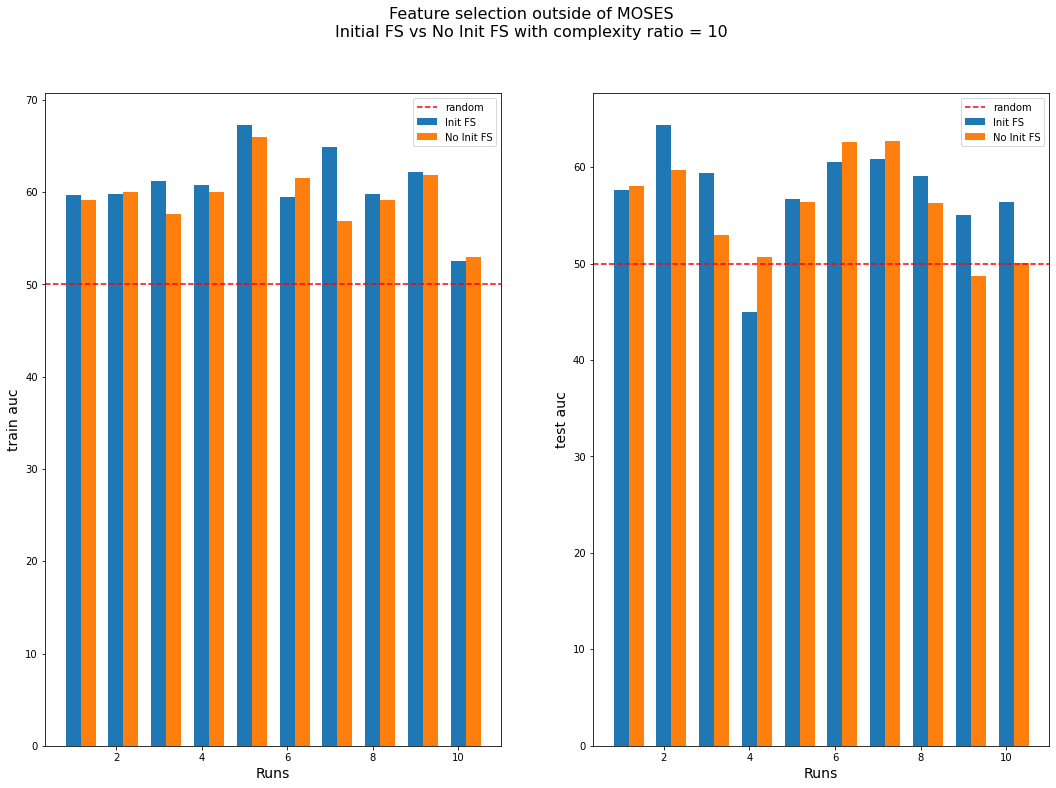

In [605]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle("Feature selection outside of MOSES\nInitial FS vs No Init FS with complexity ratio = 10", fontsize=16)

index = np.arange(1, 11)
bar_width = 0.35
ax[0].bar(index, results_fs_init_auc_df["cv_score"]*100, bar_width, label="Init FS")
ax[0].bar(index + bar_width, results_fs_auc_df["cv_score"]*100, bar_width, label="No Init FS")
ax[0].axhline(y=50, color="red", label="random", linestyle="--")
ax[0].set_xlabel("Runs", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)

ax[1].bar(index, results_fs_init_auc_df["test_score"]*100, bar_width, label="Init FS")
ax[1].bar(index + bar_width, results_fs_auc_df["test_score"]*100, bar_width, label="No Init FS")
ax[1].set_xlabel("Runs", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[1].axhline(y=50, color="red", label="random", linestyle="--")

ax[0].legend()
ax[1].legend()